In [1]:
# Making imports convenient
import sys
import os
PATH=os.getcwd().split('/notebooks')[0]
sys.path.insert(1, PATH)

In [194]:
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from datasets import load_dataset, Dataset, concatenate_datasets
import transformers
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix


from transformers import AutoTokenizer, DataCollatorWithPadding,BertForSequenceClassification,TrainingArguments,Trainer

from src.utils.myutils import *
import yaml
from tqdm import tqdm
import logging
import json
import warnings
import random
import pandas as pd
from newspaper import Article
from nltk import sent_tokenize

logging.disable(logging.ERROR)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning) 

CS_DATA_PATH = PATH + '/data/CS/processed/'
CONFIG_PATH = PATH + '/src/utils/config.yaml'
FINAL_PATH = '/home/horyctom/bias-detection-thesis/src/models/trained/final_classifier.pth'


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model_name = 'fav-kky/FERNET-C5'
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False,padding=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

BATCH_SIZE = 32

In [45]:
model = BertForSequenceClassification.from_pretrained(model_name,num_labels=2)
model.load_state_dict(torch.load(FINAL_PATH))

<All keys matched successfully>

In [196]:
def classify_sentence(sent:str):
    toksentence = tokenizer(sent,truncation=True,return_tensors="pt",max_length=128)
    model.eval()
    model.to(device)
    with torch.no_grad():
        toksentence.to(device)
        output = model(**toksentence)
    
    classification = F.softmax(output.logits,dim=1).argmax(dim=1)
    
    return classification[0].item()

In [195]:
def classify_sentence_certainty(sent:str):
    toksentence = tokenizer(sent,truncation=True,return_tensors="pt",max_length=128)
    model.eval()
    model.to(device)
    with torch.no_grad():
        toksentence.to(device)
        output = model(**toksentence)
    
    classification = F.softmax(output.logits,dim=1)
    
    return classification

In [15]:
article = Article('https://a2larm.cz/2022/03/clenky-feministickeho-protivalecneho-odporu-putinovo-rusko-je-zakleta-ziva-mrtvola/')
article.download()
article.parse()
sentences = sent_tokenize(article.text)
annotations = np.array(list(zip(sentences,list(map(classify_sentence,sentences)))))
certainity = np.array(list(zip(sentences,list(map(classify_sentence_certainty,sentences)))))



bias level:  26.08695652173913 %


In [219]:
novinky_sort = novinky.sort_values(by=['published'])

In [395]:
novinky_sort['published'][:4]

36077    2002-12-28T11:58:00+0100
8110     2003-01-01T14:15:00+0100
24514    2003-01-02T17:24:00+0100
29463    2003-01-03T09:23:00+0100
Name: published, dtype: object

In [16]:
list(filter(lambda x : x[1] == 'biased',annotations))

[array(['To bylo mimochodem velmi konsolidované – podíleli se na něm jak intelektuálové, tak dělníci.',
        'biased'], dtype='<U296'),
 array(['A my ji bereme v úvahu.', 'biased'], dtype='<U296'),
 array(['Zdá se mi, že právě u těchto lidí by bylo třeba hledat odpověď na otázku po metodologii.',
        'biased'], dtype='<U296'),
 array(['Putin denacifikuje Ukrajinu a zároveň ho v Rusku podporují neonacisté.',
        'biased'], dtype='<U296'),
 array(['Jedná se o velký problém militarismu, jímž trpí ženy, queer lidi a děti, tedy ty nejzranitelnější skupiny.',
        'biased'], dtype='<U296'),
 array(['Darja: Každá válka je pro oblast lidských práv katastrofou.',
        'biased'], dtype='<U296'),
 array(['Ničí všechny dosavadní úspěchy nevládních organizací, filantropie, feministických a queer komunit.',
        'biased'], dtype='<U296'),
 array(['Nezáleží na tom, zda jste ve vítězné nebo poražené zemi.',
        'biased'], dtype='<U296'),
 array(['Ella Rossmanová ve své studii Z

In [483]:
data = pd.read_json('/mnt/data/factcheck/summarization/sumeczech/sumeczech-1.0-test.jsonl',lines=True)
#throaway blogs
data = data[~data['subdomain'].str.contains('blog')]

In [485]:
np.unique(data['subdomain'])

array(['alik.idnes.cz', 'auto.idnes.cz', 'bonusweb.idnes.cz',
       'brno.idnes.cz', 'budejovice.idnes.cz', 'bydleni.idnes.cz',
       'byznys.lidovky.cz', 'ceskenoviny.cz', 'cestiny.idnes.cz',
       'cestovani.idnes.cz', 'cestovani.lidovky.cz', 'denik.cz',
       'ekonomika.idnes.cz', 'finance.idnes.cz', 'fotbal.idnes.cz',
       'hobby.idnes.cz', 'hradec.idnes.cz', 'jihlava.idnes.cz',
       'kraje.idnes.cz', 'kultura.zpravy.idnes.cz', 'liberec.idnes.cz',
       'lidovky.cz', 'mobil.idnes.cz', 'mobilnihry.idnes.cz',
       'novinky.cz', 'olomouc.idnes.cz', 'ona.idnes.cz',
       'ostrava.idnes.cz', 'pardubice.idnes.cz', 'plnehry.idnes.cz',
       'plzen.idnes.cz', 'pr.lidovky.cz', 'praha.idnes.cz',
       'relax.lidovky.cz', 'revue.idnes.cz', 'rungo.idnes.cz',
       'sdeleni.idnes.cz', 'sport.lidovky.cz', 'technet.idnes.cz',
       'usti.idnes.cz', 'vary.idnes.cz', 'volby.idnes.cz',
       'wiki.idnes.cz', 'xman.idnes.cz', 'zlin.idnes.cz',
       'zpravy.idnes.cz'], dtype=object)

In [455]:
denik = data[data.subdomain == 'denik.cz']

In [499]:
"alik.idnes.cz".split('.')[0]

'alik'

0          bydleni
1           zpravy
2        ekonomika
3        cestovani
4          kultura
           ...    
1025     ekonomika
1026         denik
1027       lidovky
1028    zahranicni
1029        zpravy
Name: section, Length: 1000, dtype: object

In [488]:
values = np.zeros(1000)
for i in tqdm(range(1000)):
    text = data[:1000].iloc[i]['text']
    sentences = sent_tokenize(text)
    labels = np.array(list(map(classify_sentence,sentences)))
    values[i] = 100*np.sum(labels)/len(labels)

100%|██████████| 1000/1000 [05:34<00:00,  2.99it/s]


In [502]:
dat = pd.DataFrame({'section':data[:1000]['section'].apply(lambda x: x.split('.')[0]),"Bias":values})

In [503]:
dat = dat.groupby('section').agg({'Bias':'mean'}).reset_index()

In [504]:
dat.sort_values('Bias')

,section,Bias
53,zoh10,0.000000
50,zdravi,0.000000
28,motorismus,2.272727
32,ostrava,3.567682
7,byznys,3.612197
30,olomouc,3.631288
13,ekonomika,3.912629
41,sdeleni,4.122492
17,hokej,4.505293
51,zena,5.300562


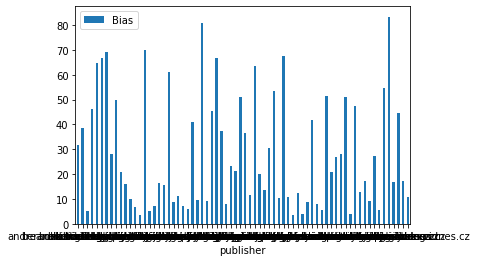

In [440]:
ax = dat.plot.bar(x='publisher', y='Bias', rot=0)

In [323]:
years = list(novinky_sort[:2000]['published'].apply(lambda x: int(x[:4])))

In [330]:
months_years = list(novinky_sort[:2000]['published'].apply(lambda x: x[:7]))

In [359]:
years_biases = pd.DataFrame({'Year':months_years,'Bias':values[:2000]})

In [377]:
df = years_biases.groupby('Year').agg({'Bias':'mean'}).rename(columns={'Bias':'mean_bias'}).reset_index()

In [ ]:
bias = pd.DataFrame({'Publisher':

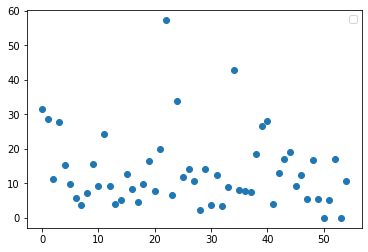

In [513]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Let's create a function to model and create data
def func(x, a, x0, sigma):
	return a*np.exp(-(x-x0)**2/(2*sigma**2))

# Generating clean data
x = range(len(dat['Bias']))
yn = dat['Bias']

# Plot out the current state of the data and model
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, yn)

# Executing curve_fit on noisy data
ym = func(x, popt[0], popt[1], popt[2])
ax.legend()
fig.savefig('model_fit.png')


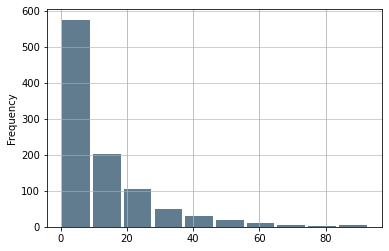

In [525]:
import pandas as pd

# Generate data on commute times.
commutes = pd.Series(values[:1000])

commutes.plot.hist(grid=True, bins=10, rwidth=0.9,
                   color='#607c8e')
plt.grid(axis='y', alpha=0.75)

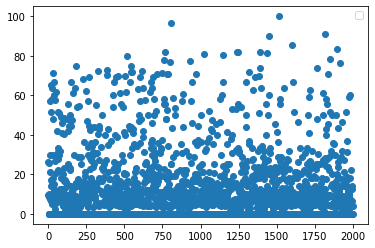

In [235]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Let's create a function to model and create data
def func(x, a, x0, sigma):
	return a*np.exp(-(x-x0)**2/(2*sigma**2))

# Generating clean data
x = np.arange(2000)
yn = values[:2000]

# Plot out the current state of the data and model
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, yn)

# Executing curve_fit on noisy data
ym = func(x, popt[0], popt[1], popt[2])
ax.legend()
fig.savefig('model_fit.png')


In [131]:
novinky = data[data.subdomain == 'novinky.cz']

In [135]:
np.unique(annotations[:,1],return_counts=True)

(array(['biased', 'unbiased'], dtype='<U230'), array([5, 1]))

In [146]:
stats

(array(['biased', 'unbiased'], dtype='<U230'), array([5, 1]))

In [148]:
text = data.iloc[41]['text']

In [153]:
sentences = sent_tokenize(text)
labels = np.array(list(map(classify_sentence,sentences)))
annotations = np.array(list(zip(sentences,list(map(classify_sentence,sentences)))))
certainity = np.array(list(zip(sentences,list(map(classify_sentence_certainty,sentences)))))

In [156]:
np.sum(labels)/len(labels)

0.8333333333333334

In [104]:
stats = np.unique(annotations[:,1],return_counts=True)
print("bias level: ",stats[1][0]/stats[1].sum()*100,"%")

bias level:  83.33333333333334 %


In [105]:
list(filter(lambda x : x[1] == 'biased',annotations))

[array(['Zobrazit fotogaleriiA zatřetí, legendě se sluší popřát: premiéru totiž měla právě na podzim před třiceti lety, třebaže k nám dorazila až za svobodné éry roku 1990.',
        'biased'], dtype='<U230'),
 array(['Tudíž oslavu třicetiletého kyborga a pětadvacetiletého Listopadu lze docela přirozeně spojit, jak potvrdí pamětníci, kteří viděli Terminátora poprvé ještě v ilegalitě 80. let, na láskyplně pašovaných a stokrát obehraných kazetách.',
        'biased'], dtype='<U230'),
 array(['Z takového pokoutního přepisu se leckdy nedalo pořádně rozpoznat, kdo je vlastně Arnold Schwarzenegger, ale mělo to i své výhody, nehrozila ztráta iluzí.',
        'biased'], dtype='<U230'),
 array(['Ani Bystrozraký by pod jeho kostýmem neodhalil napájecí baterie k laserovému zařízení, natož aby odhadl, ve které fázi hercův obličej nahradila loutka nebo kde se režisér James Cameron vmísil mezi komparz.',
        'biased'], dtype='<U230'),
 array(['Ale nostalgik to rád unese, protože v době digitální

In [100]:
classify_sentence_certainty('Lady Gaga je schopná.')

tensor([[0.0139, 0.9861]], device='cuda:0')

In [187]:
np.arange(50)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])